## Advantage actor-critic in AgentNet (5 pts)

Once we're done with REINFORCE, it's time to proceed with something more sophisticated.
The next one in line is advantage actor-critic, in which agent learns both policy and value function, using the latter to speed up learning.

Your main objective for this session is to... beat MountainCar-v0... with actor-critic.

Beating means making submission to [gym leaderboard](https://gym.openai.com/envs/MountainCar-v0).

``` MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials. ```


In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
import theano
from theano import tensor as T
%matplotlib inline

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym

env = gym.make("MountainCar-v0")
obs = env.reset()
state_size = len(obs)
n_actions = env.action_space.n
print(obs)
print("n_actions:", n_actions)

[2017-10-03 01:20:56,736] Making new env: MountainCar-v0


[-0.41727903  0.        ]
n_actions: 3


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [3]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, batch_norm, dropout

In [4]:
observation_layer = InputLayer((None, state_size))

#<your architecture>
h1 = lasagne.layers.DenseLayer(observation_layer,
                               num_units=256,
                               nonlinearity=lasagne.nonlinearities.rectify)

h2 = lasagne.layers.DenseLayer(h1,
                               num_units=128,
                               nonlinearity=lasagne.nonlinearities.rectify)

In [5]:
#a layer that predicts Qvalues
policy_layer = lasagne.layers.DenseLayer(h2,
                                         num_units=n_actions,
                                         nonlinearity=lasagne.nonlinearities.softmax)

V_layer = lasagne.layers.DenseLayer(h2,
                                    num_units=1,
                                    nonlinearity=None)

In [6]:
eps = theano.shared(np.float32(0.0), allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1. - eps) * p + eps / n_actions)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [7]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer, V_layer),
              action_layers=action_layer)

In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer, V_layer), trainable=True)
weights

[W, b, W, b, W, b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [9]:
from agentnet.experiments.openai_gym.pool import EnvPool

#create a small pool with 10 parallel agents
pool = EnvPool(agent, "MountainCar-v0", n_games=64, max_size=15000) 

#we assume that pool size 1000 is small enough to learn "almost on policy" :)

[2017-10-03 01:20:57,141] Making new env: MountainCar-v0
[2017-10-03 01:20:57,144] Making new env: MountainCar-v0
[2017-10-03 01:20:57,146] Making new env: MountainCar-v0
[2017-10-03 01:20:57,148] Making new env: MountainCar-v0
[2017-10-03 01:20:57,149] Making new env: MountainCar-v0
[2017-10-03 01:20:57,151] Making new env: MountainCar-v0
[2017-10-03 01:20:57,153] Making new env: MountainCar-v0
[2017-10-03 01:20:57,154] Making new env: MountainCar-v0
[2017-10-03 01:20:57,156] Making new env: MountainCar-v0
[2017-10-03 01:20:57,157] Making new env: MountainCar-v0
[2017-10-03 01:20:57,159] Making new env: MountainCar-v0
[2017-10-03 01:20:57,161] Making new env: MountainCar-v0
[2017-10-03 01:20:57,163] Making new env: MountainCar-v0
[2017-10-03 01:20:57,165] Making new env: MountainCar-v0
[2017-10-03 01:20:57,166] Making new env: MountainCar-v0
[2017-10-03 01:20:57,168] Making new env: MountainCar-v0
[2017-10-03 01:20:57,169] Making new env: MountainCar-v0
[2017-10-03 01:20:57,171] Makin

In [10]:
%%time
#interact for 7 ticks
_, action_log, reward_log, _, _, _ = pool.interact(7)

print(action_log[:3])
print(reward_log[:3])

[[2 2 1 1 2 0 0]
 [0 0 2 2 2 1 1]
 [0 2 1 1 2 0 0]]
[[-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 20 ms, sys: 10 ms, total: 30 ms
Wall time: 20.8 ms


In [11]:
SEQ_LENGTH = 10
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Actor-critic loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(128)

_, _, _, _,(policy_seq, V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

In [13]:
from agentnet.learning import a2c                                                   

elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,
                                                V_seq[:, :, 0],
                                                replay.actions[0],
                                                replay.rewards,
                                                replay.is_alive,
                                                gamma_or_gammas=0.99,
                                                n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()
loss += 0.01 * (1. / policy_seq).mean()

In [14]:
#<regularize agent with negative entropy. Higher entropy = smaller loss. Multiply by small coefficient>
#loss += 1e-3 * T.mean(T.sum(policy_seq*T.log(policy_seq), axis=-1))

In [15]:
# Compute weight updates
#<your favorite optimization method>
updates = lasagne.updates.rmsprop(loss, weights, learning_rate=1e-3)

In [16]:
train_step = theano.function([], loss, updates=updates)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-10-03 01:21:01,483] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Demo run

In [17]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records", record_video=True)

#video is in the ./records folder

[2017-10-03 01:21:04,549] Making new env: MountainCar-v0
[2017-10-03 01:21:04,557] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-10-03 01:21:04,564] Starting new video recorder writing to /notebooks/week6/records/openaigym.video.0.975.video000000.mp4
[2017-10-03 01:21:06,908] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')


Episode finished after 200 timesteps with reward=-200.0


# Training loop


In [18]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}

In [19]:
from tqdm import tqdm
#the loop may take eons to finish.
#consider interrupting early.
loss = 0
eps_val = 1.0
for i in tqdm(range(10000)):
    
    eps_val *= 0.998
    eps.set_value(eps_val)
    
    #train    
    for _ in range(10):
        pool.update(SEQ_LENGTH, append=True)
    
    for _ in range(10):
        loss = loss * 0.99 + train_step() * 0.01

    if epoch_counter % 100 == 0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        print("iter=%i\treward/step=%.5f\tloss ma=%.5f" % (epoch_counter,
                                                           pool_mean_reward,
                                                           loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter % 500 == 0:
        n_games = 20
        eps.set_value(0)
        rewards[epoch_counter] = pool.evaluate(record_video=False,
                                               n_games=n_games,
                                               verbose=False)
        
        print("Current score(mean over %i) = %.3f"%(n_games, np.mean(rewards[epoch_counter])))
    
    
    epoch_counter += 1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:21<36:34,  4.51it/s]

iter=100	reward/step=-0.99762	loss ma=19.78468


  2%|▏         | 200/10000 [00:43<36:13,  4.51it/s]

iter=200	reward/step=-0.99762	loss ma=19.69263


  3%|▎         | 300/10000 [01:05<34:52,  4.64it/s]

iter=300	reward/step=-0.99739	loss ma=19.77358


  4%|▍         | 400/10000 [01:27<34:01,  4.70it/s]

iter=400	reward/step=-0.99739	loss ma=19.55072


  5%|▍         | 499/10000 [01:48<34:18,  4.62it/s][2017-10-03 01:22:55,610] Making new env: MountainCar-v0
[2017-10-03 01:22:55,613] Clearing 4 monitor files from previous run (because force=True was provided)


iter=500	reward/step=-0.99762	loss ma=19.39235


[2017-10-03 01:22:56,287] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
  5%|▌         | 500/10000 [01:49<1:06:29,  2.38it/s]

Current score(mean over 20) = -200.000


  6%|▌         | 600/10000 [02:11<33:45,  4.64it/s]  

iter=600	reward/step=-0.99762	loss ma=19.58169


  7%|▋         | 700/10000 [02:32<33:09,  4.67it/s]

iter=700	reward/step=-0.99753	loss ma=19.68910


  8%|▊         | 800/10000 [02:54<33:00,  4.64it/s]

iter=800	reward/step=-0.99739	loss ma=19.65603


  9%|▉         | 900/10000 [03:15<32:53,  4.61it/s]

iter=900	reward/step=-0.99739	loss ma=18.86553


 10%|▉         | 999/10000 [03:37<32:29,  4.62it/s][2017-10-03 01:24:44,589] Making new env: MountainCar-v0
[2017-10-03 01:24:44,594] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	reward/step=-0.99762	loss ma=19.37908


[2017-10-03 01:24:45,179] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 10%|█         | 1000/10000 [03:38<59:07,  2.54it/s]

Current score(mean over 20) = -200.000


 11%|█         | 1100/10000 [04:00<32:42,  4.54it/s]

iter=1100	reward/step=-0.99762	loss ma=19.40000


 12%|█▏        | 1200/10000 [04:22<31:47,  4.61it/s]

iter=1200	reward/step=-0.99739	loss ma=18.73780


 13%|█▎        | 1300/10000 [04:43<32:14,  4.50it/s]

iter=1300	reward/step=-0.99739	loss ma=19.21088


 14%|█▍        | 1400/10000 [05:05<31:17,  4.58it/s]

iter=1400	reward/step=-0.99762	loss ma=19.85541


 15%|█▍        | 1499/10000 [05:27<30:55,  4.58it/s][2017-10-03 01:26:34,544] Making new env: MountainCar-v0
[2017-10-03 01:26:34,549] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	reward/step=-0.99762	loss ma=19.56484


[2017-10-03 01:26:35,132] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 15%|█▌        | 1500/10000 [05:28<56:05,  2.53it/s]

Current score(mean over 20) = -200.000


 16%|█▌        | 1600/10000 [05:49<30:28,  4.59it/s]

iter=1600	reward/step=-0.99753	loss ma=19.27067


 17%|█▋        | 1700/10000 [06:12<32:19,  4.28it/s]

iter=1700	reward/step=-0.99739	loss ma=18.92389


 18%|█▊        | 1800/10000 [06:34<29:47,  4.59it/s]

iter=1800	reward/step=-0.99739	loss ma=19.26984


 19%|█▉        | 1900/10000 [06:55<29:07,  4.64it/s]

iter=1900	reward/step=-0.99762	loss ma=18.75282


 20%|█▉        | 1999/10000 [07:17<29:12,  4.57it/s][2017-10-03 01:28:24,498] Making new env: MountainCar-v0
[2017-10-03 01:28:24,503] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	reward/step=-0.99762	loss ma=19.13521


[2017-10-03 01:28:25,097] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 20%|██        | 2000/10000 [07:18<53:07,  2.51it/s]

Current score(mean over 20) = -200.000


 21%|██        | 2100/10000 [07:39<28:22,  4.64it/s]

iter=2100	reward/step=-0.99739	loss ma=18.77139


 22%|██▏       | 2200/10000 [08:01<28:23,  4.58it/s]

iter=2200	reward/step=-0.99739	loss ma=18.65465


 23%|██▎       | 2300/10000 [08:23<28:00,  4.58it/s]

iter=2300	reward/step=-0.99762	loss ma=15.46185


 24%|██▍       | 2400/10000 [08:44<27:30,  4.60it/s]

iter=2400	reward/step=-0.99741	loss ma=7.21635


 25%|██▍       | 2499/10000 [09:06<27:53,  4.48it/s][2017-10-03 01:30:14,041] Making new env: MountainCar-v0
[2017-10-03 01:30:14,046] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	reward/step=-0.99723	loss ma=2.14842


[2017-10-03 01:30:14,577] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 25%|██▌       | 2500/10000 [09:07<48:09,  2.60it/s]

Current score(mean over 20) = -177.050


 26%|██▌       | 2600/10000 [09:29<27:27,  4.49it/s]

iter=2600	reward/step=-0.99693	loss ma=0.69849


 27%|██▋       | 2700/10000 [09:52<27:57,  4.35it/s]

iter=2700	reward/step=-0.99684	loss ma=0.34638


 28%|██▊       | 2800/10000 [10:15<27:21,  4.39it/s]

iter=2800	reward/step=-0.99674	loss ma=0.16829


 29%|██▉       | 2900/10000 [10:38<29:20,  4.03it/s]

iter=2900	reward/step=-0.99676	loss ma=0.15229


 30%|██▉       | 2999/10000 [11:01<26:23,  4.42it/s][2017-10-03 01:32:08,354] Making new env: MountainCar-v0
[2017-10-03 01:32:08,360] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	reward/step=-0.99674	loss ma=0.12393


[2017-10-03 01:32:08,805] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 30%|███       | 3000/10000 [11:01<42:19,  2.76it/s]

Current score(mean over 20) = -148.750


 31%|███       | 3100/10000 [11:24<25:47,  4.46it/s]

iter=3100	reward/step=-0.99671	loss ma=0.10158


 32%|███▏      | 3200/10000 [11:47<25:24,  4.46it/s]

iter=3200	reward/step=-0.99666	loss ma=0.11273


 33%|███▎      | 3300/10000 [12:09<24:50,  4.50it/s]

iter=3300	reward/step=-0.99664	loss ma=0.16909


 34%|███▍      | 3400/10000 [12:32<24:55,  4.41it/s]

iter=3400	reward/step=-0.99655	loss ma=0.18138


 35%|███▍      | 3499/10000 [12:54<24:14,  4.47it/s][2017-10-03 01:34:01,774] Making new env: MountainCar-v0
[2017-10-03 01:34:01,779] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	reward/step=-0.99654	loss ma=0.19018


[2017-10-03 01:34:02,215] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 35%|███▌      | 3500/10000 [12:55<38:33,  2.81it/s]

Current score(mean over 20) = -146.000


 36%|███▌      | 3600/10000 [13:17<24:03,  4.43it/s]

iter=3600	reward/step=-0.99641	loss ma=0.26475


 37%|███▋      | 3700/10000 [13:40<24:16,  4.32it/s]

iter=3700	reward/step=-0.99648	loss ma=0.28205


 38%|███▊      | 3800/10000 [14:03<23:06,  4.47it/s]

iter=3800	reward/step=-0.99639	loss ma=0.29903


 39%|███▉      | 3900/10000 [14:25<23:00,  4.42it/s]

iter=3900	reward/step=-0.99631	loss ma=0.31788


 40%|███▉      | 3999/10000 [14:47<22:11,  4.51it/s][2017-10-03 01:35:54,975] Making new env: MountainCar-v0
[2017-10-03 01:35:54,980] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	reward/step=-0.99630	loss ma=0.32052


[2017-10-03 01:35:55,380] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 40%|████      | 4000/10000 [14:48<34:28,  2.90it/s]

Current score(mean over 20) = -136.300


 41%|████      | 4100/10000 [15:10<22:06,  4.45it/s]

iter=4100	reward/step=-0.99622	loss ma=0.34436


 42%|████▏     | 4200/10000 [15:33<21:54,  4.41it/s]

iter=4200	reward/step=-0.99623	loss ma=0.38923


 43%|████▎     | 4300/10000 [15:56<22:12,  4.28it/s]

iter=4300	reward/step=-0.99619	loss ma=0.34994


 44%|████▍     | 4400/10000 [16:19<21:08,  4.41it/s]

iter=4400	reward/step=-0.99616	loss ma=0.37234


 45%|████▍     | 4499/10000 [16:41<20:39,  4.44it/s][2017-10-03 01:37:49,040] Making new env: MountainCar-v0
[2017-10-03 01:37:49,045] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	reward/step=-0.99616	loss ma=0.35983


[2017-10-03 01:37:49,426] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 45%|████▌     | 4500/10000 [16:42<31:22,  2.92it/s]

Current score(mean over 20) = -113.450


 46%|████▌     | 4600/10000 [17:05<20:13,  4.45it/s]

iter=4600	reward/step=-0.99606	loss ma=0.32534


 47%|████▋     | 4700/10000 [17:27<19:54,  4.44it/s]

iter=4700	reward/step=-0.99606	loss ma=0.34475


 48%|████▊     | 4800/10000 [17:50<19:38,  4.41it/s]

iter=4800	reward/step=-0.99608	loss ma=0.37585


 49%|████▉     | 4900/10000 [18:12<19:09,  4.44it/s]

iter=4900	reward/step=-0.99608	loss ma=0.37871


 50%|████▉     | 4999/10000 [18:35<18:53,  4.41it/s][2017-10-03 01:39:42,565] Making new env: MountainCar-v0
[2017-10-03 01:39:42,569] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	reward/step=-0.99600	loss ma=0.40043


[2017-10-03 01:39:42,994] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 50%|█████     | 5000/10000 [18:36<29:43,  2.80it/s]

Current score(mean over 20) = -140.850


 51%|█████     | 5100/10000 [18:58<18:30,  4.41it/s]

iter=5100	reward/step=-0.99606	loss ma=0.37555


 52%|█████▏    | 5200/10000 [19:21<18:15,  4.38it/s]

iter=5200	reward/step=-0.99601	loss ma=0.39320


 53%|█████▎    | 5300/10000 [19:44<17:50,  4.39it/s]

iter=5300	reward/step=-0.99600	loss ma=0.40032


 54%|█████▍    | 5400/10000 [20:07<17:38,  4.35it/s]

iter=5400	reward/step=-0.99605	loss ma=0.40659


 55%|█████▍    | 5499/10000 [20:30<17:05,  4.39it/s][2017-10-03 01:41:37,491] Making new env: MountainCar-v0
[2017-10-03 01:41:37,496] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	reward/step=-0.99600	loss ma=0.38900


[2017-10-03 01:41:37,926] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 55%|█████▌    | 5500/10000 [20:30<26:59,  2.78it/s]

Current score(mean over 20) = -129.500


 56%|█████▌    | 5600/10000 [20:53<16:56,  4.33it/s]

iter=5600	reward/step=-0.99603	loss ma=0.34977


 57%|█████▋    | 5700/10000 [21:16<16:21,  4.38it/s]

iter=5700	reward/step=-0.99600	loss ma=0.40109


 58%|█████▊    | 5800/10000 [21:39<16:01,  4.37it/s]

iter=5800	reward/step=-0.99605	loss ma=0.37947


 59%|█████▉    | 5900/10000 [22:02<15:35,  4.38it/s]

iter=5900	reward/step=-0.99598	loss ma=0.38501


 60%|█████▉    | 5999/10000 [22:25<15:19,  4.35it/s][2017-10-03 01:43:32,361] Making new env: MountainCar-v0
[2017-10-03 01:43:32,368] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	reward/step=-0.99604	loss ma=0.41547


[2017-10-03 01:43:32,737] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 60%|██████    | 6000/10000 [22:25<22:56,  2.91it/s]

Current score(mean over 20) = -119.300


 61%|██████    | 6100/10000 [22:48<14:48,  4.39it/s]

iter=6100	reward/step=-0.99604	loss ma=0.42441


 62%|██████▏   | 6200/10000 [23:11<14:31,  4.36it/s]

iter=6200	reward/step=-0.99595	loss ma=0.40440


 63%|██████▎   | 6300/10000 [23:34<14:05,  4.38it/s]

iter=6300	reward/step=-0.99604	loss ma=0.40642


 64%|██████▍   | 6400/10000 [23:57<13:56,  4.30it/s]

iter=6400	reward/step=-0.99604	loss ma=0.39067


 65%|██████▍   | 6499/10000 [24:19<13:22,  4.36it/s][2017-10-03 01:45:27,197] Making new env: MountainCar-v0
[2017-10-03 01:45:27,203] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	reward/step=-0.99609	loss ma=0.41225


[2017-10-03 01:45:27,588] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 65%|██████▌   | 6500/10000 [24:20<20:18,  2.87it/s]

Current score(mean over 20) = -123.300


 66%|██████▌   | 6600/10000 [24:43<13:01,  4.35it/s]

iter=6600	reward/step=-0.99605	loss ma=0.40799


 67%|██████▋   | 6700/10000 [25:06<12:37,  4.36it/s]

iter=6700	reward/step=-0.99611	loss ma=0.39165


 68%|██████▊   | 6800/10000 [25:29<12:20,  4.32it/s]

iter=6800	reward/step=-0.99606	loss ma=0.46140


 69%|██████▉   | 6900/10000 [25:52<11:58,  4.32it/s]

iter=6900	reward/step=-0.99607	loss ma=0.43693


 70%|██████▉   | 6999/10000 [26:14<11:24,  4.39it/s][2017-10-03 01:47:22,215] Making new env: MountainCar-v0
[2017-10-03 01:47:22,219] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	reward/step=-0.99610	loss ma=0.46796


[2017-10-03 01:47:22,606] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 70%|███████   | 7000/10000 [26:15<17:19,  2.89it/s]

Current score(mean over 20) = -128.400


 71%|███████   | 7100/10000 [26:38<11:02,  4.38it/s]

iter=7100	reward/step=-0.99605	loss ma=0.39777


 72%|███████▏  | 7200/10000 [27:01<10:43,  4.35it/s]

iter=7200	reward/step=-0.99608	loss ma=0.42207


 73%|███████▎  | 7300/10000 [27:24<10:16,  4.38it/s]

iter=7300	reward/step=-0.99605	loss ma=0.45921


 74%|███████▍  | 7400/10000 [27:47<09:55,  4.36it/s]

iter=7400	reward/step=-0.99608	loss ma=0.45183


 75%|███████▍  | 7499/10000 [28:10<09:32,  4.36it/s][2017-10-03 01:49:17,310] Making new env: MountainCar-v0
[2017-10-03 01:49:17,315] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	reward/step=-0.99612	loss ma=0.42858


[2017-10-03 01:49:17,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 75%|███████▌  | 7500/10000 [28:10<14:29,  2.87it/s]

Current score(mean over 20) = -125.450


 76%|███████▌  | 7600/10000 [28:33<09:09,  4.36it/s]

iter=7600	reward/step=-0.99611	loss ma=0.46619


 77%|███████▋  | 7700/10000 [28:56<08:51,  4.33it/s]

iter=7700	reward/step=-0.99607	loss ma=0.50559


 78%|███████▊  | 7800/10000 [29:19<08:21,  4.38it/s]

iter=7800	reward/step=-0.99607	loss ma=0.45647


 79%|███████▉  | 7900/10000 [29:42<07:59,  4.38it/s]

iter=7900	reward/step=-0.99608	loss ma=0.47403


 80%|███████▉  | 7999/10000 [30:05<07:40,  4.34it/s][2017-10-03 01:51:12,306] Making new env: MountainCar-v0
[2017-10-03 01:51:12,311] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	reward/step=-0.99612	loss ma=0.56546


[2017-10-03 01:51:12,710] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 80%|████████  | 8000/10000 [30:05<11:44,  2.84it/s]

Current score(mean over 20) = -133.100


 81%|████████  | 8100/10000 [30:28<07:16,  4.36it/s]

iter=8100	reward/step=-0.99607	loss ma=0.50886


 82%|████████▏ | 8200/10000 [30:51<06:53,  4.36it/s]

iter=8200	reward/step=-0.99614	loss ma=0.53176


 83%|████████▎ | 8300/10000 [31:14<06:27,  4.39it/s]

iter=8300	reward/step=-0.99607	loss ma=0.54796


 84%|████████▍ | 8400/10000 [31:37<06:07,  4.35it/s]

iter=8400	reward/step=-0.99615	loss ma=0.51935


 85%|████████▍ | 8499/10000 [32:00<05:41,  4.40it/s][2017-10-03 01:53:07,354] Making new env: MountainCar-v0
[2017-10-03 01:53:07,359] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	reward/step=-0.99608	loss ma=0.54995


[2017-10-03 01:53:07,751] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 85%|████████▌ | 8500/10000 [32:00<08:41,  2.88it/s]

Current score(mean over 20) = -125.400


 86%|████████▌ | 8600/10000 [32:23<05:20,  4.37it/s]

iter=8600	reward/step=-0.99611	loss ma=0.49253


 87%|████████▋ | 8700/10000 [32:46<04:56,  4.38it/s]

iter=8700	reward/step=-0.99610	loss ma=0.52699


 88%|████████▊ | 8800/10000 [33:09<04:34,  4.37it/s]

iter=8800	reward/step=-0.99611	loss ma=0.47049


 89%|████████▉ | 8900/10000 [33:32<04:13,  4.34it/s]

iter=8900	reward/step=-0.99609	loss ma=0.47556


 90%|████████▉ | 8999/10000 [33:55<03:49,  4.37it/s][2017-10-03 01:55:02,465] Making new env: MountainCar-v0
[2017-10-03 01:55:02,470] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	reward/step=-0.99610	loss ma=0.46716


[2017-10-03 01:55:02,852] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 90%|█████████ | 9000/10000 [33:55<05:48,  2.87it/s]

Current score(mean over 20) = -126.300


 91%|█████████ | 9100/10000 [34:18<03:26,  4.35it/s]

iter=9100	reward/step=-0.99617	loss ma=0.50835


 92%|█████████▏| 9200/10000 [34:41<03:02,  4.38it/s]

iter=9200	reward/step=-0.99611	loss ma=0.49336


 93%|█████████▎| 9300/10000 [35:04<02:41,  4.35it/s]

iter=9300	reward/step=-0.99604	loss ma=0.41617


 94%|█████████▍| 9400/10000 [35:27<02:17,  4.37it/s]

iter=9400	reward/step=-0.99597	loss ma=0.40816


 95%|█████████▍| 9499/10000 [35:50<01:55,  4.35it/s][2017-10-03 01:56:57,496] Making new env: MountainCar-v0
[2017-10-03 01:56:57,501] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	reward/step=-0.99604	loss ma=0.48728


[2017-10-03 01:56:57,906] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
 95%|█████████▌| 9500/10000 [35:50<02:56,  2.84it/s]

Current score(mean over 20) = -132.100


 96%|█████████▌| 9600/10000 [36:13<01:31,  4.37it/s]

iter=9600	reward/step=-0.99610	loss ma=0.53257


 97%|█████████▋| 9700/10000 [36:36<01:08,  4.37it/s]

iter=9700	reward/step=-0.99605	loss ma=0.49695


 98%|█████████▊| 9800/10000 [36:59<00:47,  4.22it/s]

iter=9800	reward/step=-0.99603	loss ma=0.50110


 99%|█████████▉| 9900/10000 [37:22<00:22,  4.37it/s]

iter=9900	reward/step=-0.99607	loss ma=0.43211


100%|█████████▉| 9999/10000 [37:45<00:00,  4.37it/s][2017-10-03 01:58:52,688] Making new env: MountainCar-v0
[2017-10-03 01:58:52,693] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	reward/step=-0.99601	loss ma=0.48352


[2017-10-03 01:58:53,069] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week6/records')
100%|██████████| 10000/10000 [37:46<00:00,  2.91it/s]

Current score(mean over 20) = -125.450


In [20]:
iters, session_rewards = zip(*sorted(rewards.items(), key=lambda k: k[0]))

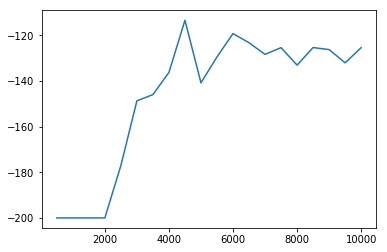

In [21]:
plt.plot(iters, list(map(np.mean, session_rewards)))

### Visualizing the $V(s)$ and  $\pi(a|s)$

Since the observation space is just 2-dimensional, we can plot it on a 2d scatter-plot to gain insight of what agent learned.

In [ ]:
_, _, _, _, (pool_policy, pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

In [ ]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()
action_names=["left","stop","right"]
for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')

### Variations in the algorithm (2 pts)

Try different `n_steps` param to see if it improves learning performance.

Your objective is to compare learning curves for 1, 3, 10 and 25-step updates (or any grid you think is appropriate).

For 25-step updates, please also increase SEQ_LENGTH to 25.

Also evaluate how performance changes with different entropy regularizer coefficient.

_bonus_ See if you can learn effectively without experience replay (may need a lot of parallel agents)

In [ ]:
#<a lot of your code here>

### Bonus section (5+ pts)

Beat the [`LunarLanderContinuous-v2`](https://gym.openai.com/envs/LunarLanderContinuous-v2) with continuous version of advantage actor-critic.

You will require a multidimensional gaussian (or similar) policy from your agent.

You can implement that by feeding a2c.get_elementwise_objective probabilities of agent's chosen actions (it will be 2-dimensional) instead of all actions.

Contact us if you have any questions.